<a href="https://colab.research.google.com/github/yusufX019/assymetric_FFNN/blob/colab/FFNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Импортируем данные из Гугл диска на котором МНИСТ данные 
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Импортируем нужные библиотеки

In [ ]:
import numpy as np
import time
import matplotlib.ticker as mticker
import matplotlib.pyplot
%matplotlib inline

Загружаем данные МНИСТ из гугл диска


In [ ]:
# Данные для обучения 
# mnist_train_x => архив изображений
# mnist_train_y => архив цифр в численном виде каждого изображения
mnist_train_x = "/content/drive/MyDrive/FFNN_project/train-images.idx3-ubyte"
mnist_train_y = "/content/drive/MyDrive/FFNN_project/train-labels.idx1-ubyte"

# Данные для тестинга
# mnist_test_x => архив изображений
# mnist_test_y => архив цифр в численном виде каждого изображения
mnist_test_x = "/content/drive/MyDrive/FFNN_project/t10k-images.idx3-ubyte"
mnist_test_y = "/content/drive/MyDrive/FFNN_project/t10k-labels.idx1-ubyte"

Функция для преобразования ubyte данных в csv 

In [ ]:
# функция получающая на вход:
# -> изображение
# -> лейбл (численное представления изображения)
# -> выходной файл
def convert(imgf, labelf, outf, n):
    f = open(imgf, "rb")
    o = open(outf, "w")
    l = open(labelf, "rb")

    f.read(16)
    l.read(8)
    images = []

    for i in range(n):
        image = [ord(l.read(1))]
        for j in range(28*28):
            image.append(ord(f.read(1)))
        images.append(image)

    for image in images:
        o.write(",".join(str(pix) for pix in image)+"\n")
    f.close()
    o.close()
    l.close()

Конвертация ubyte в csv

In [ ]:
# Конвертация данных обучения
convert(mnist_train_x, mnist_train_y, "/content/drive/MyDrive/FFNN_project/train.csv", 60000)

# Конвертация тестовых данных
convert(mnist_test_x, mnist_test_y, "/content/drive/MyDrive/FFNN_project/test.csv", 10000)

In [ ]:
Визуализация данных

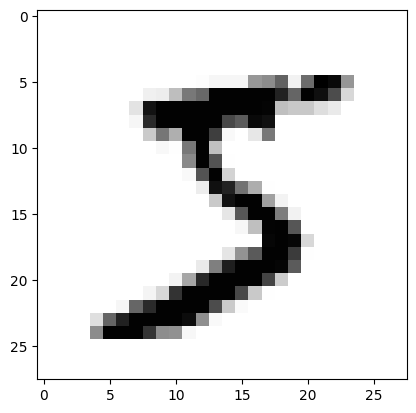

In [ ]:
# Открываем файл для чтения и считываем каждую строку в массив string
train_file = open("/content/drive/MyDrive/FFNN_project/train.csv", "r")
train_list = train_file.readlines()
train_file.close()

test_file = open("/content/drive/MyDrive/FFNN_project/test.csv", 'r')
test_list = test_file.readlines()
test_file.close()

# Форматируем данную строку виде 28х28 и передаем matplotlib
values = train_list[0].split(",")
image_array = np.asfarray(values[1:]).reshape((28,28))
matplotlib.pyplot.imshow(image_array, cmap='Greys', interpolation='None')



In [ ]:
Класс в котором будет реализованы все основные функции сети

In [ ]:
class FFNN:
  def __init__(self, sizes, epochs, lr):
    self.sizes = sizes
    self.epochs = epochs
    self.lr = lr

    # Количество состовляющих в каждом слое нс
    input_layer = self.sizes[0]    # Входной слой
    hidden_1 = self.sizes[1]       # Первый скрытый слой
    hidden_2 = self.sizes[2]       # Второй скрытый слой
    output_layer = self.sizes[3]   # Выходной слой


    # распределение весов
    # W1 - Между входный слоем и первым скрытым слоем
    # W2 - Между первым скрытм слоем и вторым 
    # W3 - Между вторым скрытым слоем и выходным слоем
    self.params = {
        'W1':np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),         # 784x128 комбинаций
        'W2':np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),            # 128x64 комбинаций
        'W3':np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer)     # 64x10 комбинаций
    }

  # Функция сигмоиды
  def sigmoid(self, x, derivative=False):
      if derivative:
          return (np.exp(-x))/((np.exp(-x)+1)**2)
      return 1/(1 + np.exp(-x))
  
  # Функция софт макс
  def softmax(self, x, derivative=False):
      # Numerically stable with large exponentials
      exps = np.exp(x - x.max())
      if derivative:
          return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
      return exps / np.sum(exps, axis=0)
  

  
  '''
    Алгоритм прямого распростронения

  '''
  def forward_pass(self, x_train):
      params = self.params

      # Значения активации нейронов входного слоя
      params['A0'] = x_train

      # Значения активации нейронов первого скрытого слоя
      params['Z1'] = np.dot(params["W1"], params['A0'])
      params['A1'] = self.sigmoid(params['Z1'])

      # Значения активацци нейронов второго скрытого слоя
      params['Z2'] = np.dot(params["W2"], params['A1'])
      params['A2'] = self.sigmoid(params['Z2'])

      # Значения нейронов выходного слоя по которым будет оцениваться результрующий выбор НС
      params['Z3'] = np.dot(params["W3"], params['A2'])
      params['A3'] = self.softmax(params['Z3'])

      return params['A3']


  '''
    Функция обратного распространения

  '''
  def backward_pass(self, y_train, output):
      params = self.params
      change_w = {}

      # Рассчитываем ошибку
      error = 2 * (output - y_train) / output.shape[0] * self.softmax(params['Z3'], derivative=True)
      change_w['W3'] = np.outer(error, params['A2'])

      # Рассчитываем веса W2
      error = np.dot(params['W3'].T, error) * self.sigmoid(params['Z2'], derivative=True)
      change_w['W2'] = np.outer(error, params['A1'])

      # Рассчитываем веса W3
      error = np.dot(params['W2'].T, error) * self.sigmoid(params['Z1'], derivative=True)
      change_w['W1'] = np.outer(error, params['A0'])

      return change_w


  # Функция для обновления весов
  def update_network_parameters(self, changes_to_w):
      for key, value in changes_to_w.items():
          self.params[key] -= self.lr * value


  def draw_graphics(self, acc_y):
      epochs_x = [i for i in range(1, self.epochs+1)]
      matplotlib.pyplot.plot(epochs_x, acc_y)
      matplotlib.pyplot.fill_between(epochs_x, acc_y, color='lightblue')
      
      matplotlib.pyplot.xlabel("№ Эпохи")
      matplotlib.pyplot.ylabel("Точность")

      plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(1.0))

      plt.title('Показатель точность при каждой эпохе')
      plt.show()



  # Функция тестирования НС
  def compute_accuracy(self, test_data):
      '''
        Данная функция повторяет логику функции функции train
        Только на этот раз используется данные для тестирования

      '''
      predictions = []

      for x in test_data:
          all_values = x.split(',')
          inputs = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
          targets = np.zeros(10) + 0.01
          targets[int(all_values[0])] = 0.99
          output = self.forward_pass(inputs)
          pred = np.argmax(output)
          predictions.append(pred == np.argmax(targets))
      
      return np.mean(predictions)


  # Функция обучения
  def train(self, train_list, test_list):
      start_time = time.time()
      accurancies_y=[]
      for iteration in range(self.epochs):
          
          # Обрабатываем каждое изоброжения в списке
          for x in train_list:
              all_values = x.split(',')
              
              # Нормализация значения яркости пикселя
              inputs = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
              
              # Создаем массив(вектор) выходных нейронов сети
              # Помечаем правильный ответ 0.99 а все остальные 0.01
              targets = np.zeros(10) + 0.01
              targets[int(all_values[0])] = 0.99

              # Получаем результаты выходных слоем путем прямого распространения
              # Рассчитываем ошибку и обновляем все веса путем обратного распространения
              output = self.forward_pass(inputs)
              changes_to_w = self.backward_pass(targets, output)
              self.update_network_parameters(changes_to_w)
          
          accuracy = self.compute_accuracy(test_list)
          accurancies_y.append(accuracy)
          print('Epoch: {0}, Time Spent: {1:.2f}s, Accuracy: {2:.2f}%'.format(
              iteration+1, time.time() - start_time, accuracy * 100
          ))

      # Отображаем данные в виде графика
      self.draw_graphics(accurancies_y)
      

    
      


Epoch: 1, Time Spent: 37.77s, Accuracy: 55.02%
Epoch: 2, Time Spent: 77.30s, Accuracy: 60.38%
Epoch: 3, Time Spent: 115.37s, Accuracy: 63.44%
Epoch: 4, Time Spent: 151.50s, Accuracy: 68.41%
Epoch: 5, Time Spent: 189.47s, Accuracy: 73.44%
Epoch: 6, Time Spent: 227.55s, Accuracy: 75.26%
Epoch: 7, Time Spent: 265.69s, Accuracy: 75.73%
Epoch: 8, Time Spent: 303.50s, Accuracy: 75.98%
Epoch: 9, Time Spent: 341.60s, Accuracy: 76.47%
Epoch: 10, Time Spent: 381.24s, Accuracy: 77.47%
Epoch: 11, Time Spent: 419.71s, Accuracy: 78.53%
Epoch: 12, Time Spent: 457.88s, Accuracy: 79.37%
Epoch: 13, Time Spent: 496.35s, Accuracy: 80.00%
Epoch: 14, Time Spent: 533.60s, Accuracy: 81.51%
Epoch: 15, Time Spent: 571.74s, Accuracy: 85.41%
Epoch: 16, Time Spent: 610.48s, Accuracy: 87.21%
Epoch: 17, Time Spent: 648.61s, Accuracy: 88.01%
Epoch: 18, Time Spent: 688.73s, Accuracy: 88.55%
Epoch: 19, Time Spent: 727.10s, Accuracy: 88.89%
Epoch: 20, Time Spent: 765.67s, Accuracy: 89.44%


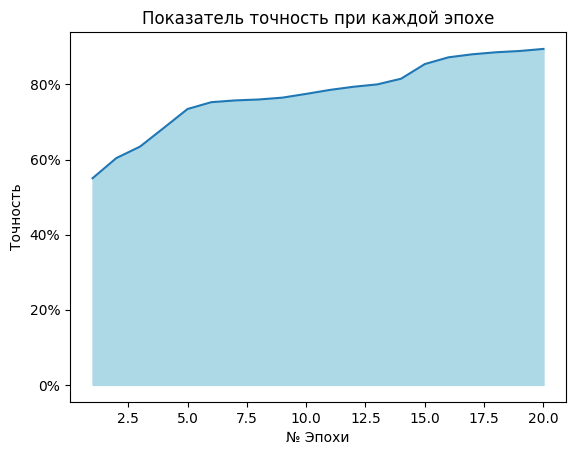

In [ ]:
ffnn = FFNN(sizes=[784, 128, 64, 10], epochs=20, lr=0.01)
ffnn.train(train_list, test_list)